In [1]:
import os
import math
import random
import numpy as np
from PIL import Image
from shutil import copyfile, rmtree
import matplotlib.pyplot as plt

from tqdm import tqdm
from termcolor import colored

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import load_model
from tensorflow.keras.layers.experimental import preprocessing

from keras.callbacks import Callback

from swish import Swish
from SoftmaxCosineSim import SoftmaxCosineSim

In [2]:
batch_size = 64
img_height = 224
img_width = 224
num_classes = 2

In [3]:
random.seed(42)

# Load data

In [6]:
print("Face pose data:")

data_dir = os.path.join("Semisupervised", "properly_separated_cfp-dataset")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

face_pose_train_ds = image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    shuffle=True,
    batch_size=batch_size)

face_pose_val_ds = image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(img_height, img_width),
    shuffle=True,
    batch_size=batch_size)

face_pose_train_ds = face_pose_train_ds.repeat()
face_pose_train_ds = face_pose_train_ds.prefetch(tf.data.experimental.AUTOTUNE)

face_pose_val_ds = face_pose_val_ds.prefetch(tf.data.experimental.AUTOTUNE)

Face pose data:
Found 6288 files belonging to 2 classes.
Found 700 files belonging to 2 classes.


# Build model

In [57]:
def unfreeze_model(model, num_layers):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        layer.trainable = False
    for layer in model.layers[-num_layers:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    return model

def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    model.layers[-1].trainable = True
    return model

def build_model_pretrained(num_layers_unfreeze):
    file_path = "Facial Emotion Recognition/AffectNet/120GB/SimCLRv1/models/new/base_model/base_model_efficientnet_color_distort_true_crop_true_flip_true_blur_true_more_data.h5"
    simclr = load_model(file_path, custom_objects={"Swish": Swish, "SoftmaxCosineSim": SoftmaxCosineSim})
    
    img_augmentation = Sequential(
        [
            preprocessing.RandomRotation(factor=0.15),
            preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
            preprocessing.RandomFlip(mode="horizontal"),
            preprocessing.RandomContrast(factor=0.1),
        ],
        name="img_augmentation",
    )
    
    inputs = layers.Input(shape=(img_height, img_width, 3))
    layer = img_augmentation(inputs)
    layer = simclr(layer)
    
    layer = layers.GlobalAveragePooling2D(name="avg_pool")(layer)
    layer = layers.BatchNormalization()(layer)
    
    layer = layers.Dense(1024)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.ReLU()(layer)
    layer = layers.Dropout(0.2)(layer)
    
    layer = layers.Dense(512)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.ReLU()(layer)
    layer = layers.Dropout(0.2)(layer)
    
    face_pose_output = layers.Dense(1, activation='sigmoid')(layer)
    face_pose_model = Model(inputs, face_pose_output)

    face_pose_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
    face_pose_model.compile(
        optimizer=face_pose_optimizer, loss="binary_crossentropy"
    )
    
    face_pose_model = unfreeze_model(face_pose_model, num_layers_unfreeze)
    
    return face_pose_model

face_pose_model = build_model_pretrained(5)

# Compute class weights because the data is imbalanced

In [48]:
def calculate_class_weights(images_dir):
    facing_camera_count = len(os.listdir(os.path.join(images_dir, "facing")))
    not_facing_camera_count = len(os.listdir(os.path.join(images_dir, "not_facing")))

    y = [0] * facing_camera_count + [1] * not_facing_camera_count

    class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
    class_weight = {l:c for l,c in zip(np.unique(y), class_weight)}
    return class_weight

class_weight = calculate_class_weights(train_dir)

# This class calculates and prints metrics and confusion matrices after each epoch

In [18]:
class Metrics(Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data
        self.val_y_correct = self.calculate_correct_y()
        self.labels = ["facing", "not facing"]
        
    def on_epoch_end(self, epoch, logs={}):
        y_correct = []
        y_pred = []
        for batch in iter(self.validation_data):
            prediction = face_pose_model.predict(batch[0])
            prediction = np.round(prediction)
            for actual, predicted in zip(batch[1], prediction):
                y_correct.append(actual)
                y_pred.append(predicted)
        
        steps = math.ceil(len(y) / batch_size)
        print("Evaluating training loss")
        train_loss = self.model.evaluate(face_pose_train_ds, steps=steps)
        self.model.save(os.path.join("Semisupervised", "models", self.model_dir, "epoch_" + str(epoch) + "_" + str(logs["val_loss"]) + ".h5"))
        
        _val_f1 = f1_score(y_correct, y_pred, average="macro")
        _val_recall = recall_score(y_correct, y_pred, average="macro")
        _val_precision = precision_score(y_correct, y_pred, average="macro")
        
        print(_val_f1, _val_recall, _val_precision)

        logs["train_loss"] = train_loss
        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(colored(" — val_f1: {:.5f} — val_precision: {:.5f} — val_recall: {:.5f} — ".format(_val_f1, _val_precision, _val_recall), "red", attrs=["bold"]))
        print(classification_report(y_correct, y_pred, target_names=self.labels, digits=3))
        print(colored("Non-normalized", attrs=["bold"]))
        self.print_confusion_matrix(y_correct, y_pred, None)
        print(colored("Normalized by true", attrs=["bold"]))
        self.print_confusion_matrix(y_correct, y_pred, "true")
        print(colored("Normalized by prediction", attrs=["bold"]))
        self.print_confusion_matrix(y_correct, y_pred, "pred")
        
    def calculate_correct_y(self):
        batch_val_y_correct = [y for x, y in self.validation_data]
        val_y_correct = []
        for batch in batch_val_y_correct:
            for elem in batch:
                val_y_correct.append(int(elem))
        return val_y_correct
    
    def print_confusion_matrix(self, y_correct, y_pred, normalize=None):
        conf_matrix = confusion_matrix(y_correct, y_pred, normalize=normalize)
        plt.figure()
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        for i in range(conf_matrix.shape[0]):
            for j in range(conf_matrix.shape[1]):
                if normalize:
                    value = "{:.3f}".format(conf_matrix[i, j])
                else:
                    value = format(conf_matrix[i, j])
                plt.text(j, i, value,
                            ha="center", va="center",
                             color="white" if conf_matrix[i, j] == 0 else "black")
        plt.tight_layout()
        plt.colorbar()
        plt.show()

# Let's train!

In [ ]:
metrics = Metrics(valid_data=face_pose_val_ds)
metrics.model_dir = "single_task"

Epoch 1/6
99/99 [==============================] - 19s 137ms/step - loss: 0.4518 - val_loss: 0.0183
Evaluating training loss
99/99 [==============================] - 8s 79ms/step - loss: 0.0217
0.9964999999999999 0.9964999999999999 0.9964999999999999
 — val_f1: 0.99650 — val_precision: 0.99650 — val_recall: 0.99650 — 
              precision    recall  f1-score   support

      facing      0.998     0.998     0.998       500
  not facing      0.995     0.995     0.995       200

    accuracy                          0.997       700
   macro avg      0.996     0.996     0.996       700
weighted avg      0.997     0.997     0.997       700

Non-normalized


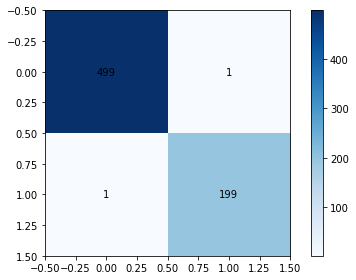

Normalized by true


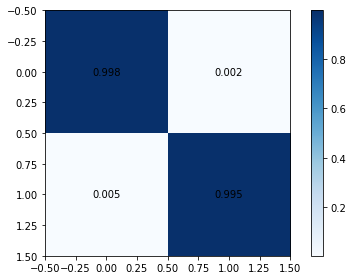

Normalized by prediction


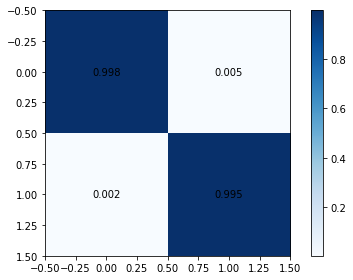

Epoch 2/6
99/99 [==============================] - 13s 128ms/step - loss: 0.1153 - val_loss: 0.0211
Evaluating training loss
99/99 [==============================] - 8s 79ms/step - loss: 0.0162
0.9894361946154775 0.9864999999999999 0.9924886621315193
 — val_f1: 0.98944 — val_precision: 0.99249 — val_recall: 0.98650 — 
              precision    recall  f1-score   support

      facing      0.990     0.998     0.994       500
  not facing      0.995     0.975     0.985       200

    accuracy                          0.991       700
   macro avg      0.992     0.986     0.989       700
weighted avg      0.991     0.991     0.991       700

Non-normalized


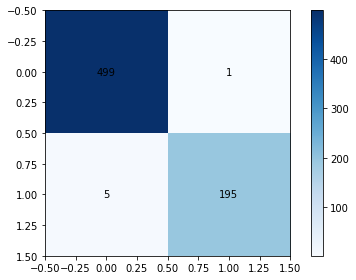

Normalized by true


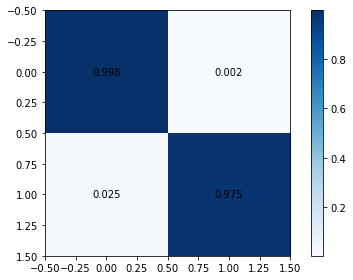

Normalized by prediction


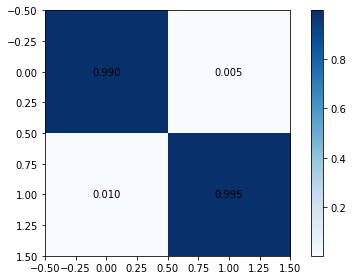

Epoch 3/6
99/99 [==============================] - 13s 128ms/step - loss: 0.0827 - val_loss: 0.0189
Evaluating training loss
99/99 [==============================] - 8s 78ms/step - loss: 0.0146
0.9947421000052579 0.994 0.9954914292018977
 — val_f1: 0.99474 — val_precision: 0.99549 — val_recall: 0.99400 — 
              precision    recall  f1-score   support

      facing      0.996     0.998     0.997       500
  not facing      0.995     0.990     0.992       200

    accuracy                          0.996       700
   macro avg      0.995     0.994     0.995       700
weighted avg      0.996     0.996     0.996       700

Non-normalized


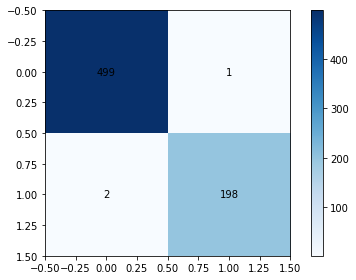

Normalized by true


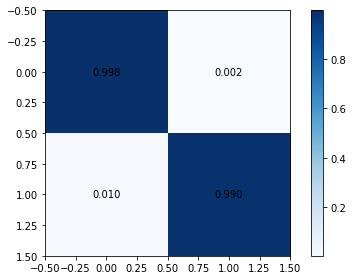

Normalized by prediction


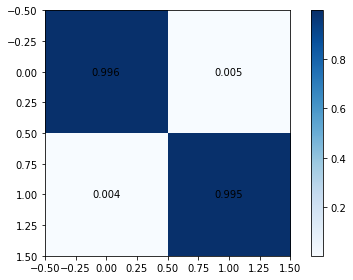

Epoch 4/6
99/99 [==============================] - 13s 129ms/step - loss: 0.0507 - val_loss: 0.0315
Evaluating training loss
99/99 [==============================] - 8s 78ms/step - loss: 0.0249
0.9878758186915286 0.993 0.9830917874396135
 — val_f1: 0.98788 — val_precision: 0.98309 — val_recall: 0.99300 — 
              precision    recall  f1-score   support

      facing      1.000     0.986     0.993       500
  not facing      0.966     1.000     0.983       200

    accuracy                          0.990       700
   macro avg      0.983     0.993     0.988       700
weighted avg      0.990     0.990     0.990       700

Non-normalized


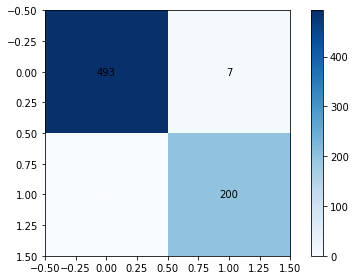

Normalized by true


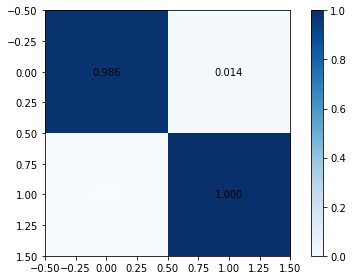

Normalized by prediction


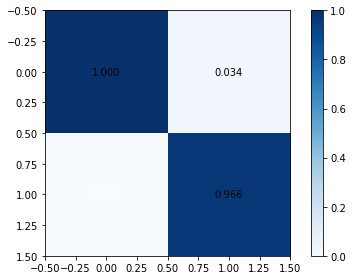

Epoch 5/6
99/99 [==============================] - 13s 131ms/step - loss: 0.0496 - val_loss: 0.2795
Evaluating training loss
99/99 [==============================] - 8s 78ms/step - loss: 0.2457
0.8746483694087619 0.921 0.8584229390681004
 — val_f1: 0.87465 — val_precision: 0.85842 — val_recall: 0.92100 — 
              precision    recall  f1-score   support

      facing      1.000     0.842     0.914       500
  not facing      0.717     1.000     0.835       200

    accuracy                          0.887       700
   macro avg      0.858     0.921     0.875       700
weighted avg      0.919     0.887     0.892       700

Non-normalized


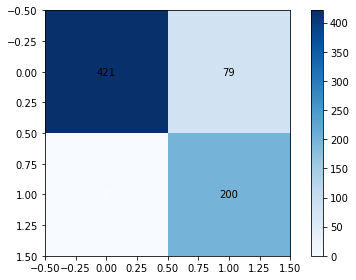

Normalized by true


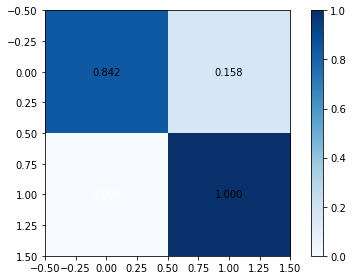

Normalized by prediction


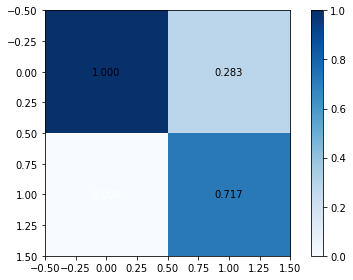

Epoch 6/6
99/99 [==============================] - 13s 128ms/step - loss: 0.0294 - val_loss: 0.0391
Evaluating training loss
99/99 [==============================] - 8s 78ms/step - loss: 0.0322
0.9844566872019322 0.991 0.9784688995215312
 — val_f1: 0.98446 — val_precision: 0.97847 — val_recall: 0.99100 — 
              precision    recall  f1-score   support

      facing      1.000     0.982     0.991       500
  not facing      0.957     1.000     0.978       200

    accuracy                          0.987       700
   macro avg      0.978     0.991     0.984       700
weighted avg      0.988     0.987     0.987       700

Non-normalized


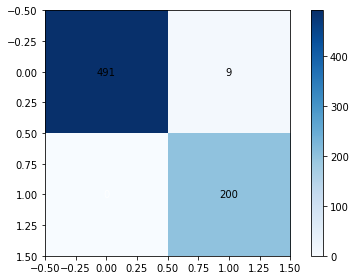

Normalized by true


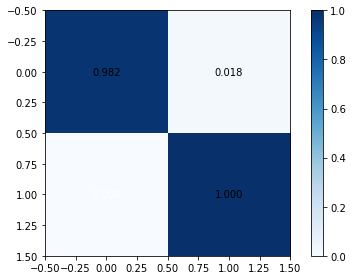

Normalized by prediction


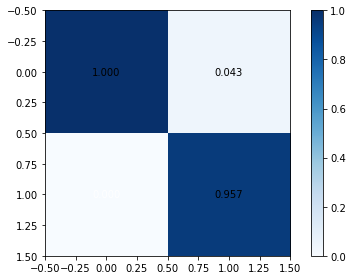

In [20]:
face_pose_model = build_model_pretrained(5)

steps_per_epoch = math.ceil(len(y) / batch_size)
epochs = 6

hist = face_pose_model.fit(face_pose_train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch, class_weight=class_weight, validation_data=face_pose_val_ds, verbose=1, batch_size=batch_size, callbacks=[metrics])
# with open(os.path.join("Semisupervised", "models", "single_task", "hist.txt"), "w") as f:
#     f.write(str(hist.history))

# We can see that epoch 0 had the lowest validation loss of 0.0183, and as such we will use early stopping